# 10-5-3 network decay tests

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import importlib
import time
from IPython.display import display
from ipywidgets import FloatProgress
from copy import deepcopy
importlib.reload(NN)
importlib.reload(Layer);

In [4]:
def ClassPlot(x, labels=[], idx=(1,2)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

## Create a simple dataset

In [5]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 29561
torch.manual_seed(seed)
np.random.seed(seed)
B = np.eye(n_classes)
X = 3.*(np.random.rand(sensory_dim, n_classes) - 0.5)
A = X.T
print('Bottom vectors')
print(B)
print('Top vectors')
print(A)
#print('System matrix:\n'+str(M))

Bottom vectors
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Top vectors
[[-0.34431496 -1.30261288  1.2664801  -1.2608779  -1.26086995 -1.00836156
   1.45235195 -1.22394346 -0.99684213  1.28417736]
 [ 0.20152066  1.28678059  0.14688571 -1.40900523 -0.59592629 -0.05049101
  -0.10055794  1.18624446  0.14322608  0.63868269]
 [-0.4448297   1.05952716  0.23670284  0.09324312  0.14226337 -0.28313644
   0.10735313 -0.58312719 -0.89823956 -0.85881006]]


In [6]:
# Use A and B to make a dataset
n_classes, top_dim = np.shape(A)
bottom_dim = n_classes

training_samples = 500
noise = 0.2
training_input = []
training_output = []
for n in range(training_samples):
    r = np.random.randint(n_classes)
    training_input.append(B[r])
    training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)
train = [training_input, training_output]

In [7]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

In [8]:
train = MakeDataset(A, B)

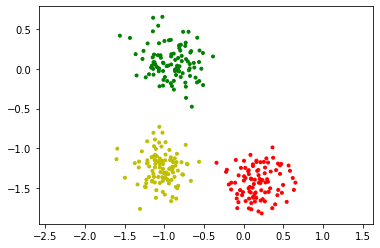

In [9]:
ClassPlot(train[1].cpu(), labels=train[0].cpu(), idx=(8,3))

## Create a Neural Network

In [29]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=n_classes))
net.AddLayer(Layer.PELayer(n=hidden_dim))
net.AddLayer(Layer.TopPELayer(n=sensory_dim))

sym = False
af = 'identity'
net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)

net.SetTau(0.2)
net.learning_tau = 0.08
net.learn_biases = False

identity
identity


## Train it on the dataset

In [11]:
net0 = deepcopy(net)

net0.SetWeightDecay(0.05)
net0.SetvDecay(0.05)
#net0.Learn(torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device), T=5., dt=0.001, epochs=10, batch_size=25)
net0.Learn(train[0], train[1], T=4., dt=0.001, epochs=4, batch_size=50, turn_down_lam=0.2)

FloatProgress(value=0.0, max=1200.0)

/Users/jorchard/Dropbox/research/peBogacz/peBogacz/python/NeuralNetwork.py:981: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c.lam = torch.tensor(w_decay).float().to(device)
/Users/jorchard/Dropbox/research/peBogacz/peBogacz/python/NeuralNetwork.py:977: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l.v_decay = torch.tensor(v_decay).float().to(device)


turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2


In [12]:
net0.layers[1].v_decay

tensor(8.0000e-05)

### Save it if you want

In [13]:
net0.Save('no_decay.npy')

### Or load one

In [ ]:
net10 = NN.NeuralNetwork()
net10.Load('no_decay.npy')

In [ ]:
net10.layers[0].v

In [ ]:
net0 = NN.NeuralNetwork()
net0.Load('no_decay.npy')

## Test how well it classifies

In [14]:
# In the backwards nomenclature, "Generate" is the feedforward direction.
mu0 = net0.Generate(5., train[1], dt=0.001)

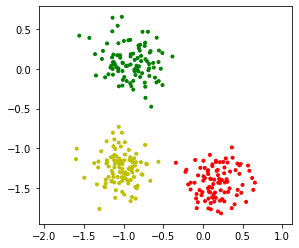

In [15]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1); ClassPlot(train[1], labels=mu0, idx=(8,3))

In [16]:
net0.layers[0].v

tensor([[ 2.0365e-02,  7.9595e-02,  8.2478e-01],
        [ 7.9665e-02,  7.6455e-01, -2.3319e-01],
        [ 9.7715e-02,  9.5912e-01,  5.3231e-02],
        [ 8.7516e-01, -1.2126e-02,  1.9638e-01],
        [ 8.3892e-01,  1.8084e-02,  2.0838e-01],
        [ 9.5232e-01,  4.1433e-03,  1.0163e-01],
        [ 4.5551e-02,  8.0282e-01,  1.0951e-01],
        [ 5.9120e-02,  1.3780e-01,  9.6593e-01],
        [ 9.6675e-02,  9.3397e-02,  7.4933e-01],
        [ 1.6240e-02, -8.4442e-02,  7.7444e-01],
        [ 8.7717e-01,  1.0372e-01,  2.9367e-01],
        [-9.7326e-03,  6.1355e-02,  7.1117e-01],
        [ 1.9870e-02,  3.5455e-02,  7.2202e-01],
        [-1.7364e-02,  9.0005e-01, -6.0218e-02],
        [ 6.1957e-02,  8.8828e-01,  6.1320e-02],
        [ 9.3732e-01, -1.6763e-02, -1.1560e-02],
        [ 8.8044e-01,  5.6607e-02,  4.4752e-02],
        [-4.4414e-02,  8.1202e-01, -7.6006e-02],
        [ 8.5368e-01,  5.7984e-02,  6.2089e-02],
        [ 9.1572e-01, -1.4906e-02, -5.5407e-03],
        [ 8.1759e-01

In [17]:
net0.dataset_accuracy(train[1], train[0], len(train[0]))

1.0

In [18]:
net0.layers[1].e

tensor([[ 0.0037, -0.0284,  0.0375, -0.0391,  0.0107],
        [-0.0044, -0.0139, -0.0213,  0.0486,  0.0332],
        [-0.0034, -0.0286, -0.0106,  0.0429,  0.0447],
        ...,
        [-0.0527,  0.0332,  0.0113,  0.0084, -0.0193],
        [ 0.0015, -0.0235,  0.0342, -0.0357,  0.0078],
        [-0.0500,  0.0249,  0.0130,  0.0097, -0.0113]])

In [19]:
netx = net0
netx.Reset()

netx.layers[0].Probe(True)
netx.layers[1].Probe(True)
netx.layers[2].Probe(True)
#mu0 = netx.Generate(5., torch.tensor(A[0,:]+some_noise/1.).float(), dt=0.001)
mu0 = netx.Generate(10., train[1][0:1], dt=0.001)

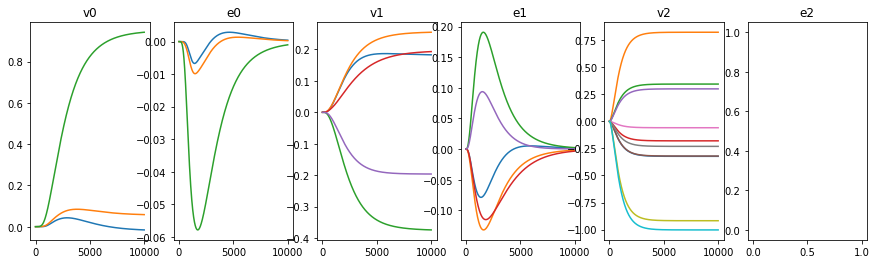

In [20]:
plt.figure(figsize=(15,4)); p = 6;
plt.subplot(1,p,1); plt.plot( netx.layers[0].v_history );
plt.title('v0')
plt.subplot(1,p,2); plt.plot(netx.layers[0].e_history); plt.title('e0')
plt.subplot(1,p,3); plt.plot(netx.layers[1].v_history); plt.title('v1')
plt.subplot(1,p,4); plt.plot(netx.layers[1].e_history); plt.title('e1')
plt.subplot(1,p,5); plt.plot(netx.layers[2].v_history); plt.title('v2')
plt.subplot(1,p,6); plt.plot(netx.layers[2].e_history); plt.title('e2');